# IT5006 Group Project - FD002

**Group 6**

Gong Yifei (A0275740B)  
Jiao Yuehan (A0290548W)  
Loh Hui Wen (A0274301R)  
Tan Xin Ying Geraldine (A0274591W)   
Zhang Junti (A0274854R)

For this dataset, we conducted **Experiment 1** and **Experiment 3**. In the "Operation system clustering" section after Experiment 1, we explored the trends for operational settings and decided to keep them and make use of the full set of sensors, and therefore Experiment 2 is skipped.

## Experiment 1: Traditional Machine Learning without Tsfresh

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import datetime

from scipy.stats import skew, kurtosis
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler


In [5]:
col_names = ['unit_id', 'cycle', 'sys1', 'sys2', 'sys3'] + [f"sensor{i}" for i in range(1, 22)]

df = pd.read_csv('data/train_FD002.txt', delim_whitespace=True, header=None, names=col_names)

### 1.2 Perform basic checks
#### Check for null/missing values
For FD002 we don't see null values:

In [6]:
for col in df.columns:
    if(df[col].isnull().any()):
        print("Column ",col," has null value(s).")
        df[col] = df.groupby('unit_id')[col].transform(lambda x: x.fillna(x.mean()))
df.describe()

,unit_id,cycle,sys1,sys2,sys3,sensor1,sensor2,sensor3,sensor4,sensor5,...,sensor12,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21
count,53759.000000,53759.000000,53759.000000,53759.000000,53759.000000,53759.000000,53759.000000,53759.000000,53759.000000,53759.000000,...,53759.000000,53759.000000,53759.000000,53759.000000,53759.000000,53759.000000,53759.000000,53759.000000,53759.000000,53759.000000
mean,131.082981,109.154746,23.998407,0.572056,94.046020,472.910207,579.672399,1419.971013,1205.442024,8.031986,...,266.069034,2334.557253,8066.597682,9.329654,0.023326,348.309511,2228.806358,97.756838,20.789296,12.473423
std,74.463862,69.180569,14.747376,0.310016,14.237735,26.389707,37.289399,105.946341,119.123428,3.613839,...,137.659507,128.068271,84.837950,0.749335,0.004711,27.754515,145.327980,5.364067,9.869331,5.921615
min,1.000000,1.000000,0.000000,0.000000,60.000000,445.000000,535.530000,1243.730000,1023.770000,3.910000,...,129.120000,2027.610000,7848.360000,8.335700,0.020000,303.000000,1915.000000,84.930000,10.180000,6.010500
25%,68.000000,52.000000,10.004600,0.250700,100.000000,445.000000,549.570000,1352.760000,1123.655000,3.910000,...,131.520000,2387.900000,8062.140000,8.677800,0.020000,331.000000,2212.000000,100.000000,10.910000,6.546300
50%,131.000000,104.000000,25.001300,0.700000,100.000000,462.540000,555.980000,1369.180000,1138.890000,7.050000,...,183.200000,2388.080000,8082.540000,9.310900,0.020000,335.000000,2223.000000,100.000000,14.880000,8.929200
75%,195.000000,157.000000,41.998000,0.840000,100.000000,491.190000,607.340000,1499.370000,1306.850000,10.520000,...,371.260000,2388.170000,8127.195000,9.386900,0.030000,369.000000,2324.000000,100.000000,28.470000,17.083200
max,260.000000,378.000000,42.008000,0.842000,100.000000,518.670000,644.520000,1612.880000,1439.230000,14.620000,...,523.370000,2390.480000,8268.500000,11.066900,0.030000,399.000000,2388.000000,100.000000,39.340000,23.590100


#### Find missing cycle per unit (if any)
For FD002 we don't see missing cycles in the raw data:

In [7]:
def find_missing_cycles(df):
    missing_cycles = {}
    for unit_id, group in df.groupby('unit_id'):
        actual_cycles = group['cycle'].values
        expected_cycles = list(range(1, group['cycle'].max() + 1))  # Create the expected cycle sequence
        missing = sorted(set(expected_cycles) - set(actual_cycles))  # Compare and find missing cycles
        if missing:
            missing_cycles[unit_id] = missing
    return missing_cycles

missing_cycles = find_missing_cycles(df)
if (len(missing_cycles)):
    print(missing_cycles)

### 1.3 Add Remaining Useful Life (RUL) as target

In [8]:
df['RUL'] = df.groupby('unit_id')['cycle'].transform(lambda x: x.max() - x).clip(upper=130)
#df

### 1.4 Exploratory Data Analysis
#### Statistical summary

In [9]:
print(df.shape)
pd.set_option('display.max_columns', None)
df.describe()

(53759, 27)


,unit_id,cycle,sys1,sys2,sys3,sensor1,sensor2,sensor3,sensor4,sensor5,sensor6,sensor7,sensor8,sensor9,sensor10,sensor11,sensor12,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21,RUL
count,53759.000000,53759.000000,53759.000000,53759.000000,53759.000000,53759.000000,53759.000000,53759.000000,53759.000000,53759.000000,53759.000000,53759.000000,53759.000000,53759.000000,53759.000000,53759.000000,53759.000000,53759.000000,53759.000000,53759.000000,53759.000000,53759.000000,53759.000000,53759.000000,53759.000000,53759.000000,53759.000000
mean,131.082981,109.154746,23.998407,0.572056,94.046020,472.910207,579.672399,1419.971013,1205.442024,8.031986,11.600746,282.606787,2228.879188,8525.200837,1.094962,42.985172,266.069034,2334.557253,8066.597682,9.329654,0.023326,348.309511,2228.806358,97.756838,20.789296,12.473423,88.818133
std,74.463862,69.180569,14.747376,0.310016,14.237735,26.389707,37.289399,105.946341,119.123428,3.613839,5.431802,146.005306,145.209816,335.812013,0.127469,3.232372,137.659507,128.068271,84.837950,0.749335,0.004711,27.754515,145.327980,5.364067,9.869331,5.921615,43.438666
min,1.000000,1.000000,0.000000,0.000000,60.000000,445.000000,535.530000,1243.730000,1023.770000,3.910000,5.710000,136.800000,1914.770000,7985.560000,0.930000,36.230000,129.120000,2027.610000,7848.360000,8.335700,0.020000,303.000000,1915.000000,84.930000,10.180000,6.010500,0.000000
25%,68.000000,52.000000,10.004600,0.250700,100.000000,445.000000,549.570000,1352.760000,1123.655000,3.910000,5.720000,139.935000,2211.880000,8321.660000,1.020000,41.910000,131.520000,2387.900000,8062.140000,8.677800,0.020000,331.000000,2212.000000,100.000000,10.910000,6.546300,51.000000
50%,131.000000,104.000000,25.001300,0.700000,100.000000,462.540000,555.980000,1369.180000,1138.890000,7.050000,9.030000,194.660000,2223.070000,8361.200000,1.020000,42.390000,183.200000,2388.080000,8082.540000,9.310900,0.020000,335.000000,2223.000000,100.000000,14.880000,8.929200,103.000000
75%,195.000000,157.000000,41.998000,0.840000,100.000000,491.190000,607.340000,1499.370000,1306.850000,10.520000,15.490000,394.080000,2323.960000,8778.030000,1.260000,45.350000,371.260000,2388.170000,8127.195000,9.386900,0.030000,369.000000,2324.000000,100.000000,28.470000,17.083200,130.000000
max,260.000000,378.000000,42.008000,0.842000,100.000000,518.670000,644.520000,1612.880000,1439.230000,14.620000,21.610000,555.820000,2388.390000,9215.660000,1.300000,48.510000,523.370000,2390.480000,8268.500000,11.066900,0.030000,399.000000,2388.000000,100.000000,39.340000,23.590100,130.000000


#### Box plot

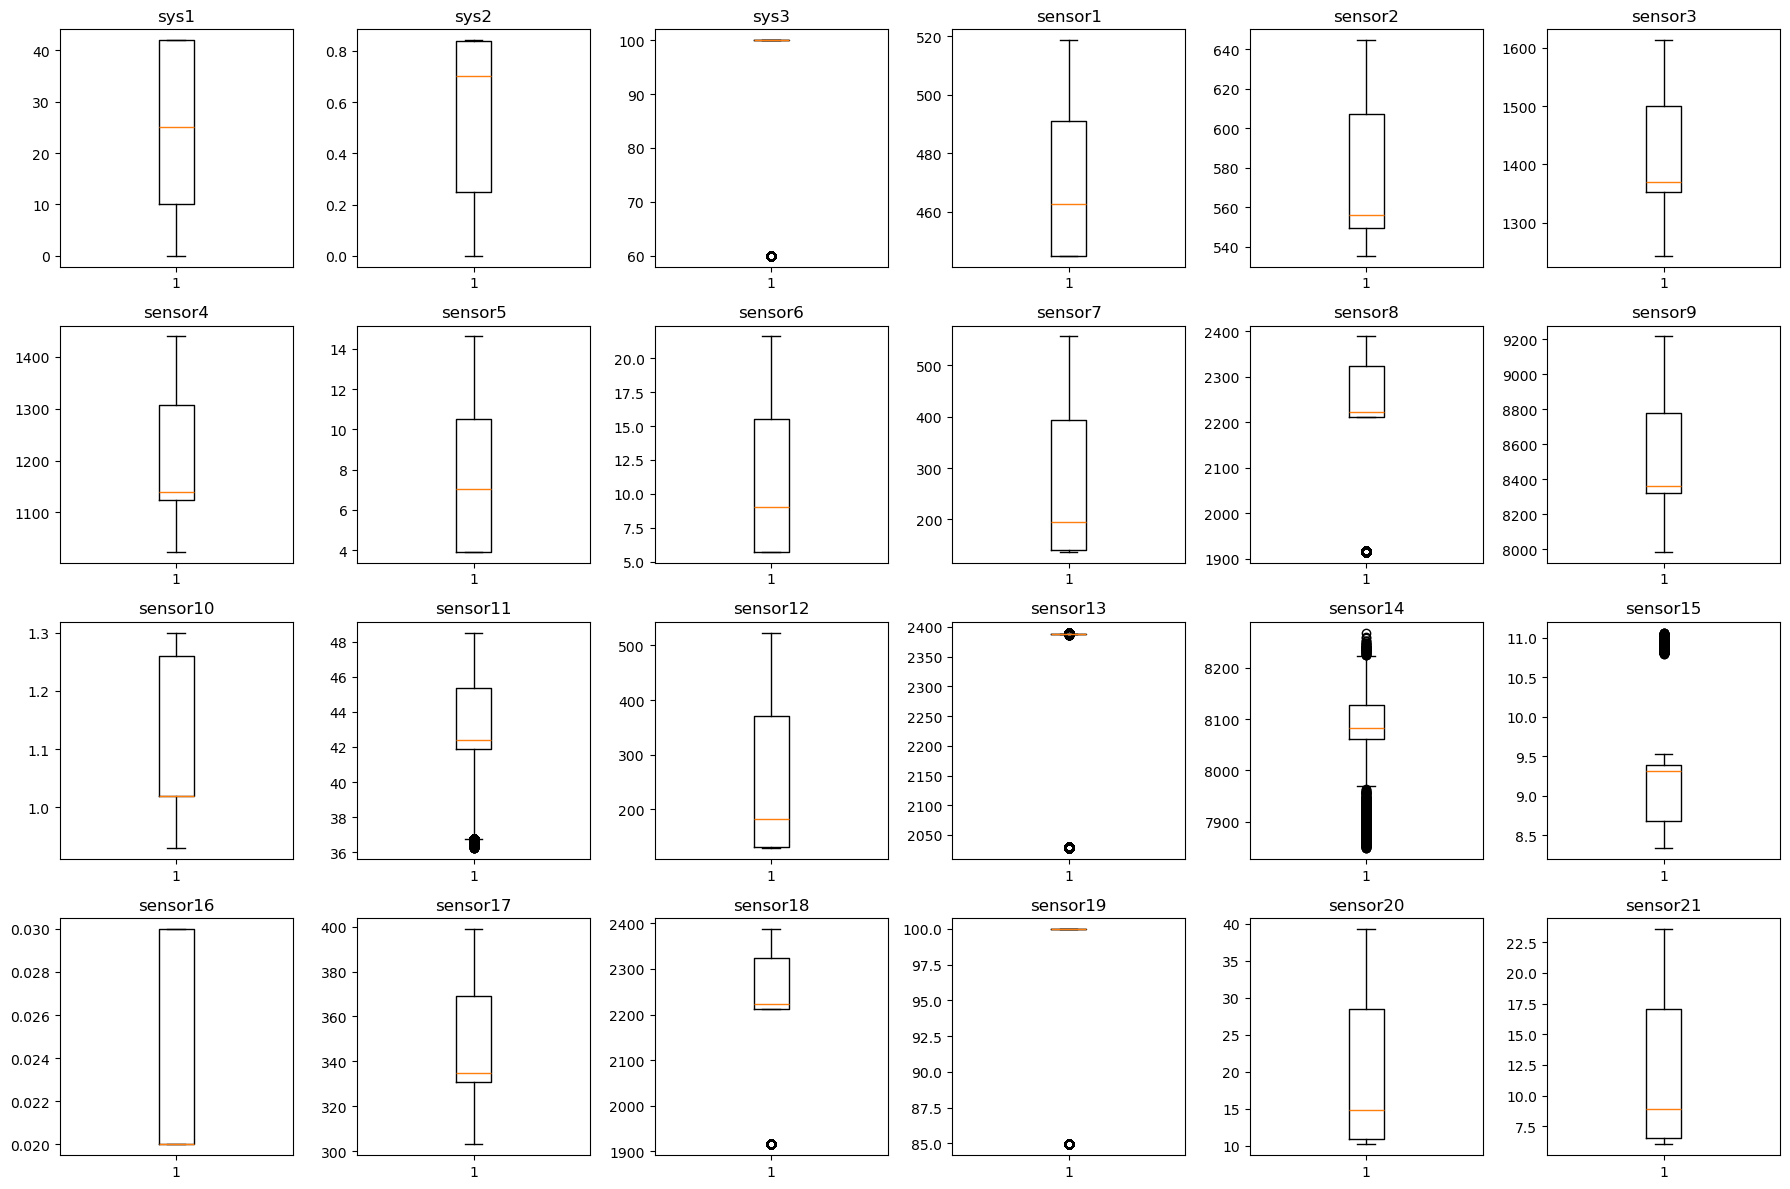

In [10]:
# Create a grid of subplots
unit_id = 1
cols = df.columns
cols = cols[~cols.isin(['unit_id', 'cycle', 'RUL'])]

fig, axes = plt.subplots(4, 6, figsize = (18, 12))
axes = axes.flatten()

for i, col in enumerate(cols):
    axes[i].boxplot(df[col])
    axes[i].set_title(col)

plt.tight_layout()
plt.show()

#### Crrelation heatmap

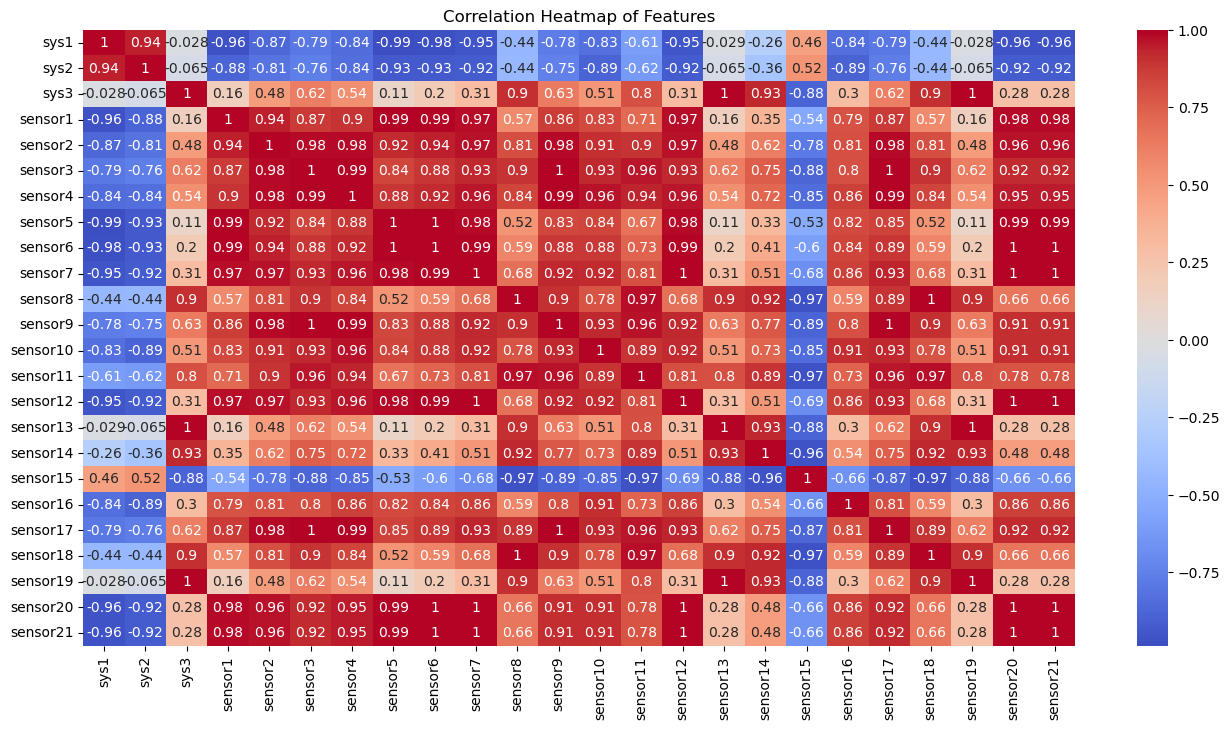

In [11]:
correlation_matrix = df[cols].corr()
plt.figure(figsize=(16, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)

plt.title('Correlation Heatmap of Features')
plt.show()

In [12]:
# Find index pairs with |correlation|>threshold
threshold = 0.99
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i + 1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            high_corr_pairs.append((correlation_matrix.columns[i], correlation_matrix.columns[j], correlation_matrix.iloc[i, j]))

# Convert to DataFrame for a cleaner view if desired
high_corr_df = pd.DataFrame(high_corr_pairs, columns=["Feature 1", "Feature 2", "Correlation"])
high_corr_df

,Feature 1,Feature 2,Correlation
0,sys3,sensor13,0.999998
1,sys3,sensor19,1.000000
2,sensor3,sensor9,0.997806
3,sensor3,sensor17,0.998680
4,sensor4,sensor17,0.990213
5,sensor5,sensor6,0.996311
6,sensor6,sensor7,0.993270
7,sensor6,sensor12,0.993096
8,sensor6,sensor20,0.996356
9,sensor6,sensor21,0.996363


From the correlation heatmap above we can see:

- {sys3, sensor13 and sensor19}
- {sensor3, sensor4, sensor9, sensor17}
- {sensor5, sensor6, sensor7, sensor12, sensor20, sensor21}
- {sensor8, sensor18}

These 4 groups of features are highly correlated. We can consider only keep one per each group.

Here's the correlation heatmap after dropping redandunt columns:

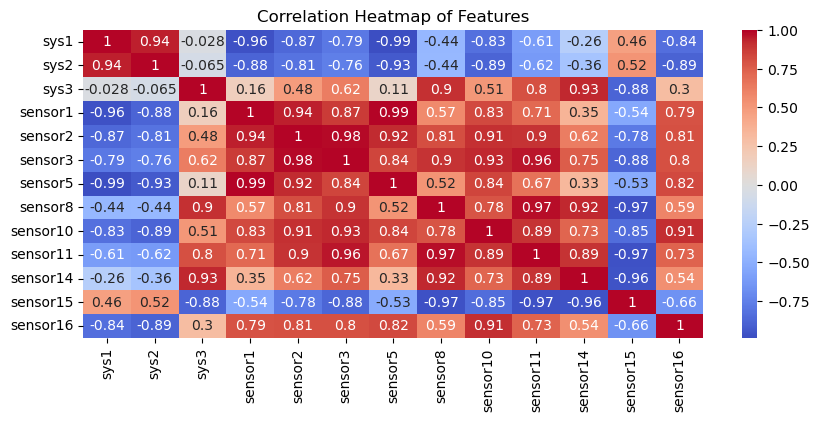

In [13]:
cols_to_drop = ['sensor13', 'sensor19', 'sensor4', 'sensor9', 'sensor17', 'sensor6', 'sensor7', 'sensor12', 'sensor20', 'sensor21', 'sensor18']
df = df.drop(columns=set(cols_to_drop).intersection(df.columns))
cols = cols[~cols.isin(cols_to_drop)]

correlation_matrix = df[cols].corr()
plt.figure(figsize=(10, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)

plt.title('Correlation Heatmap of Features')
plt.show()

### Line plot of one unit

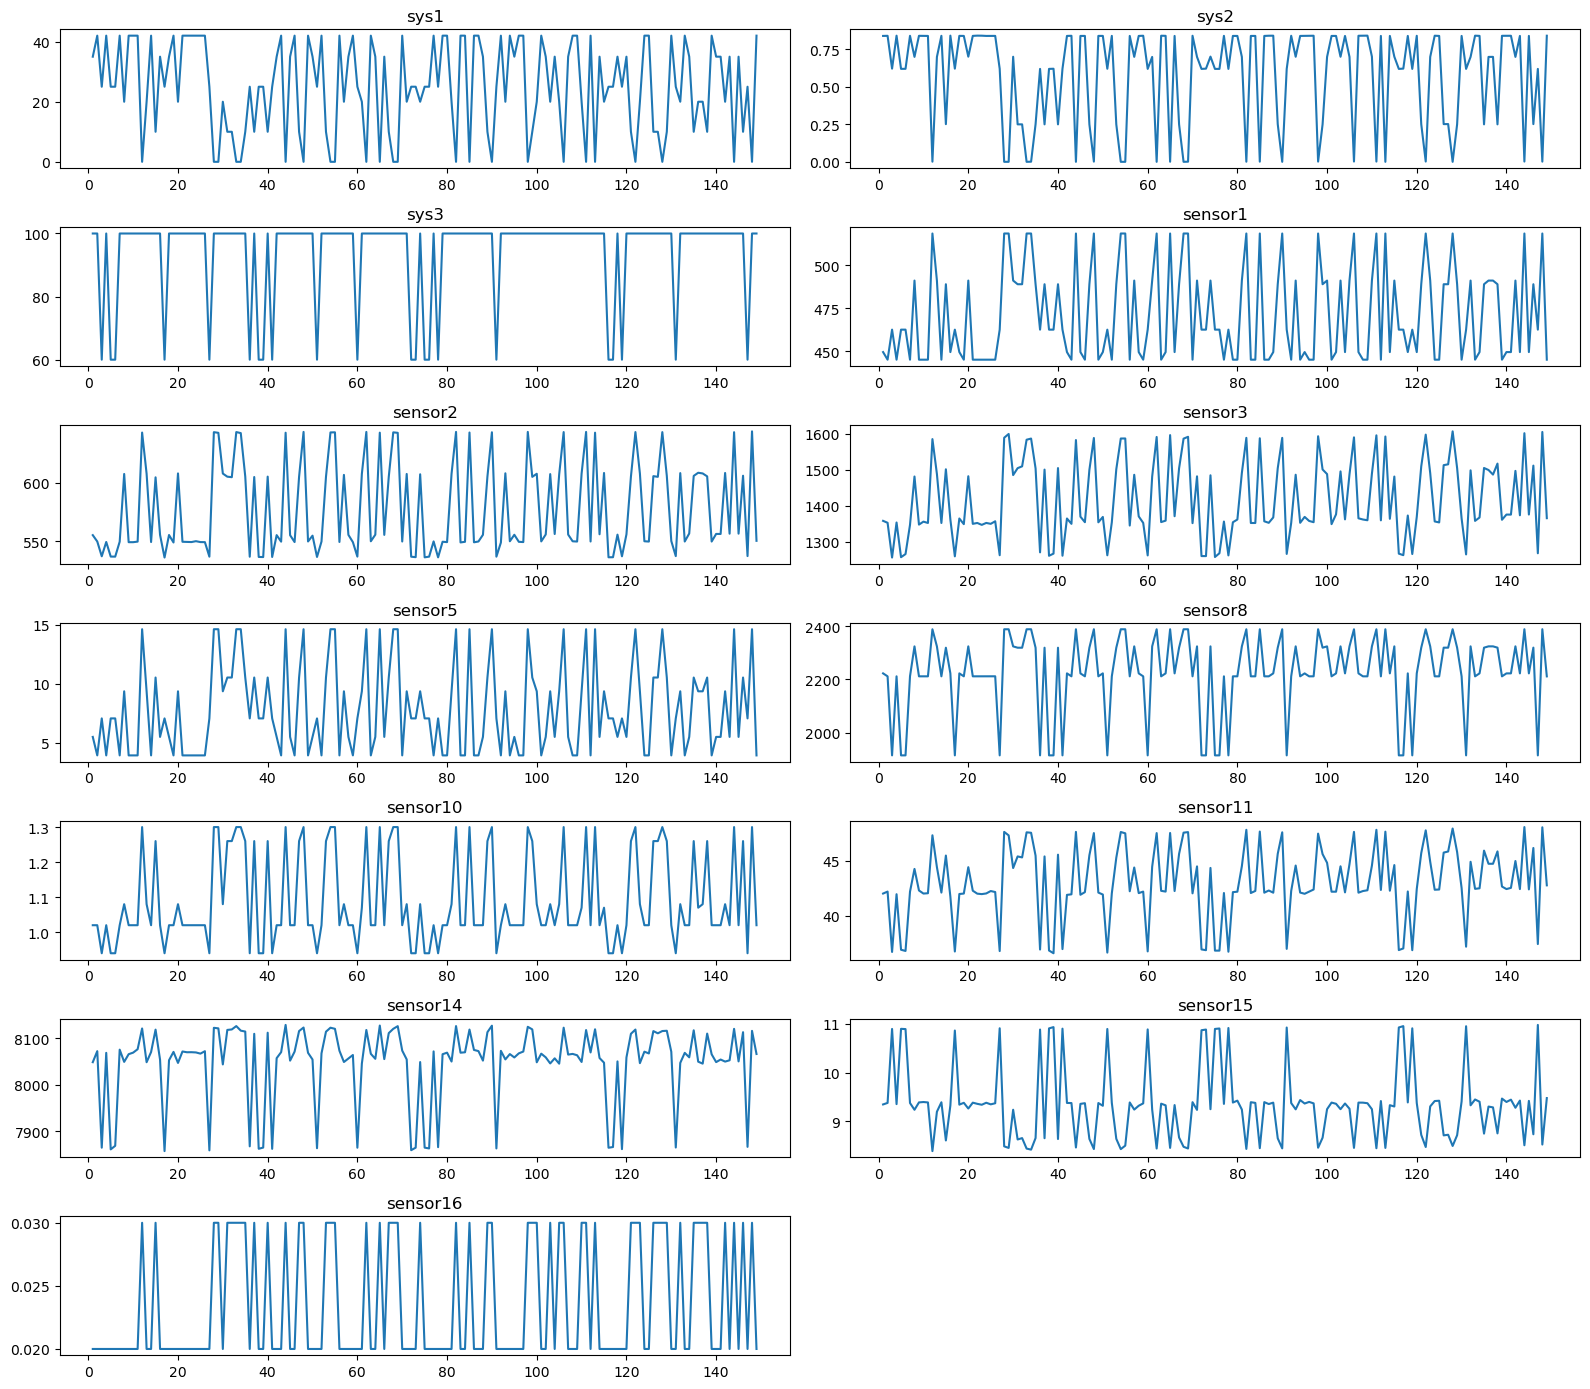

In [14]:
# Create a grid of subplots
unit_id = 1
unit_df = df[df['unit_id'] == unit_id]

fig, axes = plt.subplots(7, 2, figsize = (16, 14))
axes = axes.flatten()

for i, col in enumerate(cols):
    axes[i].plot(unit_df['cycle'], unit_df[col])
    axes[i].set_title(col)

fig.delaxes(axes[13])
plt.tight_layout()
plt.show()

Unlike dataset FD001, we don't see constant or near-constant columns, so we can keep this set of features as our initial features.

### 1.5 Feature Engineering
#### Create new features

In [15]:
def create_features(df, window_size):
    # Initialize new features dataframe
    features = pd.DataFrame()
    features['unit_id'] = df['unit_id']
    features['cycle'] = df['cycle']

    # 1. Static statistical features
    sensor_cols = [col for col in df.columns if col.startswith('sensor')]
    agg_dict = {col: ['mean', 'std', 'min', 'max', 'var', skew, kurtosis] for col in sensor_cols}
    statistical_features = df.groupby('unit_id').agg(agg_dict)
    statistical_features.columns = ['_static_'.join(col) for col in statistical_features.columns]
    features = features.merge(statistical_features, on='unit_id', how='left')

    # 2. Rolling statistical features (using window_size)
    rolling_window = []
    stat_functions = {
        'mean': np.mean,
        'std': np.std,
        'min': np.min,
        'max': np.max,
        'var': np.var,
        'skew': skew,
        'kurtosis': kurtosis
    }
    
    for stat_name, stat_function in stat_functions.items():
        rolling_result = df.groupby('unit_id').rolling(window=window_size, on='cycle')[sensor_cols].apply(stat_function).reset_index()
        rolling_result = rolling_result[sensor_cols]
        rolling_result.columns = [f'{col}_rolling_{stat_name}' for col in sensor_cols]
        rolling_window.append(rolling_result)
    
    rolling_window = pd.concat(rolling_window, axis=1)
    features = pd.concat([features, rolling_window], axis=1)

    # 3. Immediate diff feature
    for col in sensor_cols:
        features[f'{col}_diff'] = df.groupby('unit_id')[col].diff()

    # 4. Rolling trend features
    for col in sensor_cols:
        slopes = []
        for unit_id in df['unit_id'].unique():
            unit_data = df[df['unit_id'] == unit_id]
            for i in range(len(unit_data)):
                if i < window_size - 1:
                    slopes.append(0)
                else:
                    y = unit_data.iloc[i-window_size+1:i+1][col].values
                    x = np.array(range(window_size)).reshape(-1, 1)
                    model = LinearRegression().fit(x, y)
                    slopes.append(model.coef_[0])
        features[f'{col}_rolling_slope'] = slopes

    # 5. Lag features
    lag_values = [5, 10]
    for col in sensor_cols:
        for lag in lag_values:
            features[f'{col}_lag_{lag}'] = df.groupby('unit_id')[col].shift(lag)

    # 6. Rolling lag features
    rolling_lag_values = [5, 10]
    for col in sensor_cols:
        for lag in rolling_lag_values:
            features[f'{col}_rolling_lag_{lag}'] = df.groupby('unit_id')[col].shift(lag).rolling(window=window_size).mean()
                
    df_with_features = pd.concat([df, features.drop(columns=['unit_id', 'cycle']).reset_index(drop=True)], axis=1)
    return df_with_features


def create_temperature_pressure_ratio_features(df, window_size):
    # Create ratios for temperature sensors 1, 2, 3, 4 against pressure sensors 5, 6, 7
    # Due to high correlation, this map reduced to sensors 1, 2, 3 to sensor 5
    sensor_numerators = ['sensor1', 'sensor2', 'sensor3']
    sensor_denominators = ['sensor5']

    for num in sensor_numerators:
        for denom in sensor_denominators:
            df[f'tp_ratio_{num}_to_{denom}'] = df[num] / (df[denom] + 1e-6) # add a small number to avoid division by 0
            df[f'rolling_mean_ratio_{num}_to_{denom}'] = df[f'{num}_rolling_mean'] / (df[f'{denom}_rolling_mean'] + 1e-6)

    return df

In [16]:
window_size = 30
train_df = create_features(df, window_size)
train_df = create_temperature_pressure_ratio_features(train_df, window_size)
train_df.head()

,unit_id,cycle,sys1,sys2,sys3,sensor1,sensor2,sensor3,sensor5,sensor8,sensor10,sensor11,sensor14,sensor15,sensor16,RUL,sensor1_static_mean,sensor1_static_std,sensor1_static_min,sensor1_static_max,sensor1_static_var,sensor1_static_skew,sensor1_static_kurtosis,sensor2_static_mean,sensor2_static_std,sensor2_static_min,sensor2_static_max,sensor2_static_var,sensor2_static_skew,sensor2_static_kurtosis,sensor3_static_mean,sensor3_static_std,sensor3_static_min,sensor3_static_max,sensor3_static_var,sensor3_static_skew,sensor3_static_kurtosis,sensor5_static_mean,sensor5_static_std,sensor5_static_min,sensor5_static_max,sensor5_static_var,sensor5_static_skew,sensor5_static_kurtosis,sensor8_static_mean,sensor8_static_std,sensor8_static_min,sensor8_static_max,sensor8_static_var,sensor8_static_skew,sensor8_static_kurtosis,sensor10_static_mean,sensor10_static_std,sensor10_static_min,sensor10_static_max,sensor10_static_var,sensor10_static_skew,sensor10_static_kurtosis,sensor11_static_mean,sensor11_static_std,sensor11_static_min,sensor11_static_max,sensor11_static_var,sensor11_static_skew,sensor11_static_kurtosis,sensor14_static_mean,sensor14_static_std,sensor14_static_min,sensor14_static_max,sensor14_static_var,sensor14_static_skew,sensor14_static_kurtosis,sensor15_static_mean,sensor15_static_std,sensor15_static_min,sensor15_static_max,sensor15_static_var,sensor15_static_skew,sensor15_static_kurtosis,sensor16_static_mean,sensor16_static_std,sensor16_static_min,sensor16_static_max,sensor16_static_var,sensor16_static_skew,sensor16_static_kurtosis,sensor1_rolling_mean,sensor2_rolling_mean,sensor3_rolling_mean,sensor5_rolling_mean,sensor8_rolling_mean,sensor10_rolling_mean,sensor11_rolling_mean,sensor14_rolling_mean,sensor15_rolling_mean,sensor16_rolling_mean,sensor1_rolling_std,sensor2_rolling_std,sensor3_rolling_std,sensor5_rolling_std,sensor8_rolling_std,sensor10_rolling_std,sensor11_rolling_std,sensor14_rolling_std,sensor15_rolling_std,sensor16_rolling_std,sensor1_rolling_min,sensor2_rolling_min,sensor3_rolling_min,sensor5_rolling_min,sensor8_rolling_min,sensor10_rolling_min,sensor11_rolling_min,sensor14_rolling_min,sensor15_rolling_min,sensor16_rolling_min,sensor1_rolling_max,sensor2_rolling_max,sensor3_rolling_max,sensor5_rolling_max,sensor8_rolling_max,sensor10_rolling_max,sensor11_rolling_max,sensor14_rolling_max,sensor15_rolling_max,sensor16_rolling_max,sensor1_rolling_var,sensor2_rolling_var,sensor3_rolling_var,sensor5_rolling_var,sensor8_rolling_var,sensor10_rolling_var,sensor11_rolling_var,sensor14_rolling_var,sensor15_rolling_var,sensor16_rolling_var,sensor1_rolling_skew,sensor2_rolling_skew,sensor3_rolling_skew,sensor5_rolling_skew,sensor8_rolling_skew,sensor10_rolling_skew,sensor11_rolling_skew,sensor14_rolling_skew,sensor15_rolling_skew,sensor16_rolling_skew,sensor1_rolling_kurtosis,sensor2_rolling_kurtosis,sensor3_rolling_kurtosis,sensor5_rolling_kurtosis,sensor8_rolling_kurtosis,sensor10_rolling_kurtosis,sensor11_rolling_kurtosis,sensor14_rolling_kurtosis,sensor15_rolling_kurtosis,sensor16_rolling_kurtosis,sensor1_diff,sensor2_diff,sensor3_diff,sensor5_diff,sensor8_diff,sensor10_diff,sensor11_diff,sensor14_diff,sensor15_diff,sensor16_diff,sensor1_rolling_slope,sensor2_rolling_slope,sensor3_rolling_slope,sensor5_rolling_slope,sensor8_rolling_slope,sensor10_rolling_slope,sensor11_rolling_slope,sensor14_rolling_slope,sensor15_rolling_slope,sensor16_rolling_slope,sensor1_lag_5,sensor1_lag_10,sensor2_lag_5,sensor2_lag_10,sensor3_lag_5,sensor3_lag_10,sensor5_lag_5,sensor5_lag_10,sensor8_lag_5,sensor8_lag_10,sensor10_lag_5,sensor10_lag_10,sensor11_lag_5,sensor11_lag_10,sensor14_lag_5,sensor14_lag_10,sensor15_lag_5,sensor15_lag_10,sensor16_lag_5,sensor16_lag_10,sensor1_rolling_lag_5,sensor1_rolling_lag_10,sensor2_rolling_lag_5,sensor2_rolling_lag_10,sensor3_rolling_lag_5,sensor3_rolling_lag_10,sensor5_rolling_lag_5,sensor5_rolling_lag_10,sensor8_rolling_lag_5,sensor8_rolling_lag_10,sensor10_rolling_lag_5,sensor10_rolling_lag_10,sensor11_

#### Pre-processing all features

In [17]:
# Handle missing values by replacing infinite values and dropping NaNs
train_df = train_df.replace([np.inf, -np.inf], np.nan).dropna()
train_df = train_df.apply(pd.to_numeric, errors='coerce').dropna()

train_df_features = train_df.drop(columns=['unit_id','cycle','RUL'])
train_df_seq = train_df[['unit_id','cycle']]
train_df_target = train_df['RUL']

# Min-Max scaling
scaler = MinMaxScaler()
scaler.fit(train_df_features)

train_df_features_scaled = pd.DataFrame(scaler.fit_transform(train_df_features), columns=train_df_features.columns, index=train_df_features.index)
train_df_scaled = pd.concat([train_df_seq, train_df_features_scaled, train_df_target], axis=1)

train_df_scaled.describe()

,unit_id,cycle,sys1,sys2,sys3,sensor1,sensor2,sensor3,sensor5,sensor8,sensor10,sensor11,sensor14,sensor15,sensor16,sensor1_static_mean,sensor1_static_std,sensor1_static_min,sensor1_static_max,sensor1_static_var,sensor1_static_skew,sensor1_static_kurtosis,sensor2_static_mean,sensor2_static_std,sensor2_static_min,sensor2_static_max,sensor2_static_var,sensor2_static_skew,sensor2_static_kurtosis,sensor3_static_mean,sensor3_static_std,sensor3_static_min,sensor3_static_max,sensor3_static_var,sensor3_static_skew,sensor3_static_kurtosis,sensor5_static_mean,sensor5_static_std,sensor5_static_min,sensor5_static_max,sensor5_static_var,sensor5_static_skew,sensor5_static_kurtosis,sensor8_static_mean,sensor8_static_std,sensor8_static_min,sensor8_static_max,sensor8_static_var,sensor8_static_skew,sensor8_static_kurtosis,sensor10_static_mean,sensor10_static_std,sensor10_static_min,sensor10_static_max,sensor10_static_var,sensor10_static_skew,sensor10_static_kurtosis,sensor11_static_mean,sensor11_static_std,sensor11_static_min,sensor11_static_max,sensor11_static_var,sensor11_static_skew,sensor11_static_kurtosis,sensor14_static_mean,sensor14_static_std,sensor14_static_min,sensor14_static_max,sensor14_static_var,sensor14_static_skew,sensor14_static_kurtosis,sensor15_static_mean,sensor15_static_std,sensor15_static_min,sensor15_static_max,sensor15_static_var,sensor15_static_skew,sensor15_static_kurtosis,sensor16_static_mean,sensor16_static_std,sensor16_static_min,sensor16_static_max,sensor16_static_var,sensor16_static_skew,sensor16_static_kurtosis,sensor1_rolling_mean,sensor2_rolling_mean,sensor3_rolling_mean,sensor5_rolling_mean,sensor8_rolling_mean,sensor10_rolling_mean,sensor11_rolling_mean,sensor14_rolling_mean,sensor15_rolling_mean,sensor16_rolling_mean,sensor1_rolling_std,sensor2_rolling_std,sensor3_rolling_std,sensor5_rolling_std,sensor8_rolling_std,sensor10_rolling_std,sensor11_rolling_std,sensor14_rolling_std,sensor15_rolling_std,sensor16_rolling_std,sensor1_rolling_min,sensor2_rolling_min,sensor3_rolling_min,sensor5_rolling_min,sensor8_rolling_min,sensor10_rolling_min,sensor11_rolling_min,sensor14_rolling_min,sensor15_rolling_min,sensor16_rolling_min,sensor1_rolling_max,sensor2_rolling_max,sensor3_rolling_max,sensor5_rolling_max,sensor8_rolling_max,sensor10_rolling_max,sensor11_rolling_max,sensor14_rolling_max,sensor15_rolling_max,sensor16_rolling_max,sensor1_rolling_var,sensor2_rolling_var,sensor3_rolling_var,sensor5_rolling_var,sensor8_rolling_var,sensor10_rolling_var,sensor11_rolling_var,sensor14_rolling_var,sensor15_rolling_var,sensor16_rolling_var,sensor1_rolling_skew,sensor2_rolling_skew,sensor3_rolling_skew,sensor5_rolling_skew,sensor8_rolling_skew,sensor10_rolling_skew,sensor11_rolling_skew,sensor14_rolling_skew,sensor15_rolling_skew,sensor16_rolling_skew,sensor1_rolling_kurtosis,sensor2_rolling_kurtosis,sensor3_rolling_kurtosis,sensor5_rolling_kurtosis,sensor8_rolling_kurtosis,sensor10_rolling_kurtosis,sensor11_rolling_kurtosis,sensor14_rolling_kurtosis,sensor15_rolling_kurtosis,sensor16_rolling_kurtosis,sensor1_diff,sensor2_diff,sensor3_diff,sensor5_diff,sensor8_diff,sensor10_diff,sensor11_diff,sensor14_diff,sensor15_diff,sensor16_diff,sensor1_rolling_slope,sensor2_rolling_slope,sensor3_rolling_slope,sensor5_rolling_slope,sensor8_rolling_slope,sensor10_rolling_slope,sensor11_rolling_slope,sensor14_rolling_slope,sensor15_rolling_slope,sensor16_rolling_slope,sensor1_lag_5,sensor1_lag_10,sensor2_lag_5,sensor2_lag_10,sensor3_lag_5,sensor3_lag_10,sensor5_lag_5,sensor5_lag_10,sensor8_lag_5,sensor8_lag_10,sensor10_lag_5,sensor10_lag_10,sensor11_lag_5,sensor11_lag_10,sensor14_lag_5,sensor14_lag_10,sensor15_lag_5,sensor15_lag_10,sensor16_lag_5,sensor16_lag_10,sensor1_rolling_lag_5,sensor1_rolling_lag_10,sensor2_rolling_lag_5,sensor2_rolling_lag_10,sensor3_rolling_lag_5,sensor3_rolling_lag_10,sensor5_rolling_lag_5,sensor5_rolling_lag_10,sensor8_rolling_lag_5,sensor8_rolling_lag_10,sensor10_rolling_lag_5,sensor10_rolling_lag_10,sensor11_roll

### 1.6 Apply the same steps to test data set
#### Prepare X_test (test_FD002.txt)

In [18]:
test_df = pd.read_csv('data/test_FD002.txt', delim_whitespace=True, header=None, names=col_names)
test_df.drop(columns=set(cols_to_drop).intersection(test_df.columns), inplace=True)

window_size = 30
test_df = create_features(test_df, window_size)
test_df = create_temperature_pressure_ratio_features(test_df, window_size)

test_df = test_df.replace([np.inf, -np.inf], np.nan).dropna()
test_df = test_df.apply(pd.to_numeric, errors='coerce').dropna()

In [19]:
test_df_features = test_df.drop(columns=['unit_id','cycle'])
test_df_seq = test_df[['unit_id','cycle']]

# Reuse the min-max scaler fitted using training data to scale the test data
test_df_features_scaled = pd.DataFrame(scaler.fit_transform(test_df_features), columns=test_df_features.columns, index=test_df_features.index)
test_df_scaled = pd.concat([test_df_seq, test_df_features_scaled], axis=1)

# This is our X_test
test_df_scaled.describe()

,unit_id,cycle,sys1,sys2,sys3,sensor1,sensor2,sensor3,sensor5,sensor8,sensor10,sensor11,sensor14,sensor15,sensor16,sensor1_static_mean,sensor1_static_std,sensor1_static_min,sensor1_static_max,sensor1_static_var,sensor1_static_skew,sensor1_static_kurtosis,sensor2_static_mean,sensor2_static_std,sensor2_static_min,sensor2_static_max,sensor2_static_var,sensor2_static_skew,sensor2_static_kurtosis,sensor3_static_mean,sensor3_static_std,sensor3_static_min,sensor3_static_max,sensor3_static_var,sensor3_static_skew,sensor3_static_kurtosis,sensor5_static_mean,sensor5_static_std,sensor5_static_min,sensor5_static_max,sensor5_static_var,sensor5_static_skew,sensor5_static_kurtosis,sensor8_static_mean,sensor8_static_std,sensor8_static_min,sensor8_static_max,sensor8_static_var,sensor8_static_skew,sensor8_static_kurtosis,sensor10_static_mean,sensor10_static_std,sensor10_static_min,sensor10_static_max,sensor10_static_var,sensor10_static_skew,sensor10_static_kurtosis,sensor11_static_mean,sensor11_static_std,sensor11_static_min,sensor11_static_max,sensor11_static_var,sensor11_static_skew,sensor11_static_kurtosis,sensor14_static_mean,sensor14_static_std,sensor14_static_min,sensor14_static_max,sensor14_static_var,sensor14_static_skew,sensor14_static_kurtosis,sensor15_static_mean,sensor15_static_std,sensor15_static_min,sensor15_static_max,sensor15_static_var,sensor15_static_skew,sensor15_static_kurtosis,sensor16_static_mean,sensor16_static_std,sensor16_static_min,sensor16_static_max,sensor16_static_var,sensor16_static_skew,sensor16_static_kurtosis,sensor1_rolling_mean,sensor2_rolling_mean,sensor3_rolling_mean,sensor5_rolling_mean,sensor8_rolling_mean,sensor10_rolling_mean,sensor11_rolling_mean,sensor14_rolling_mean,sensor15_rolling_mean,sensor16_rolling_mean,sensor1_rolling_std,sensor2_rolling_std,sensor3_rolling_std,sensor5_rolling_std,sensor8_rolling_std,sensor10_rolling_std,sensor11_rolling_std,sensor14_rolling_std,sensor15_rolling_std,sensor16_rolling_std,sensor1_rolling_min,sensor2_rolling_min,sensor3_rolling_min,sensor5_rolling_min,sensor8_rolling_min,sensor10_rolling_min,sensor11_rolling_min,sensor14_rolling_min,sensor15_rolling_min,sensor16_rolling_min,sensor1_rolling_max,sensor2_rolling_max,sensor3_rolling_max,sensor5_rolling_max,sensor8_rolling_max,sensor10_rolling_max,sensor11_rolling_max,sensor14_rolling_max,sensor15_rolling_max,sensor16_rolling_max,sensor1_rolling_var,sensor2_rolling_var,sensor3_rolling_var,sensor5_rolling_var,sensor8_rolling_var,sensor10_rolling_var,sensor11_rolling_var,sensor14_rolling_var,sensor15_rolling_var,sensor16_rolling_var,sensor1_rolling_skew,sensor2_rolling_skew,sensor3_rolling_skew,sensor5_rolling_skew,sensor8_rolling_skew,sensor10_rolling_skew,sensor11_rolling_skew,sensor14_rolling_skew,sensor15_rolling_skew,sensor16_rolling_skew,sensor1_rolling_kurtosis,sensor2_rolling_kurtosis,sensor3_rolling_kurtosis,sensor5_rolling_kurtosis,sensor8_rolling_kurtosis,sensor10_rolling_kurtosis,sensor11_rolling_kurtosis,sensor14_rolling_kurtosis,sensor15_rolling_kurtosis,sensor16_rolling_kurtosis,sensor1_diff,sensor2_diff,sensor3_diff,sensor5_diff,sensor8_diff,sensor10_diff,sensor11_diff,sensor14_diff,sensor15_diff,sensor16_diff,sensor1_rolling_slope,sensor2_rolling_slope,sensor3_rolling_slope,sensor5_rolling_slope,sensor8_rolling_slope,sensor10_rolling_slope,sensor11_rolling_slope,sensor14_rolling_slope,sensor15_rolling_slope,sensor16_rolling_slope,sensor1_lag_5,sensor1_lag_10,sensor2_lag_5,sensor2_lag_10,sensor3_lag_5,sensor3_lag_10,sensor5_lag_5,sensor5_lag_10,sensor8_lag_5,sensor8_lag_10,sensor10_lag_5,sensor10_lag_10,sensor11_lag_5,sensor11_lag_10,sensor14_lag_5,sensor14_lag_10,sensor15_lag_5,sensor15_lag_10,sensor16_lag_5,sensor16_lag_10,sensor1_rolling_lag_5,sensor1_rolling_lag_10,sensor2_rolling_lag_5,sensor2_rolling_lag_10,sensor3_rolling_lag_5,sensor3_rolling_lag_10,sensor5_rolling_lag_5,sensor5_rolling_lag_10,sensor8_rolling_lag_5,sensor8_rolling_lag_10,sensor10_rolling_lag_5,sensor10_rolling_lag_10,sensor11_roll

#### Prepare y_test (RUL_FD002.txt)

In [20]:
RUL_df = pd.read_csv('data/RUL_FD002.txt', delim_whitespace=True, header=None, names=['RUL'])
RUL_df['unit_id'] = range(1, len(RUL_df) + 1)
RUL_df['RUL'] = RUL_df['RUL'].clip(upper=130)

### 1.7 Build random forest model using all features

In [25]:
from sklearn.model_selection import train_test_split,GridSearchCV,TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

def fit_model(X, y, model, param_grid):
    # Set up TimeSeriesSplit for time-series cross-validation
    tscv = TimeSeriesSplit(n_splits=3)
    
    # Perform Grid Search
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=tscv, 
                               scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)
    grid_search.fit(X, y)
    return grid_search

def get_best_rmse(model, X_train, X_test):
    # get results for train set
    y_pred = model.predict(X_train)
    y_train = train_df_scaled['RUL']

    train_mse = mean_squared_error(y_train, y_pred)
    train_rmse = np.sqrt(train_mse)
    print(f'Root Mean Squared Error (RMSE) for train set prediction: {train_rmse}')

    # get results for test set
    y_pred = model.predict(X_test)
    y_pred_df = pd.DataFrame({'unit_id': test_df_scaled['unit_id'].values, 'RUL_pred': y_pred}).groupby('unit_id').tail(1)
    test_res_df = pd.merge(y_pred_df, RUL_df, on='unit_id', how='left')

    test_mse = mean_squared_error(test_res_df['RUL'], test_res_df['RUL_pred'])
    test_rmse = np.sqrt(test_mse)
    print(f'Root Mean Squared Error (RMSE) for test set prediction: {test_rmse}')
    
    return test_res_df

def plot_feature_importances(model, cols, n):
    feature_importance = model.feature_importances_
    indices = np.argsort(feature_importance)[::-1][:n]

    top_features = feature_importance[indices]
    top_feature_names = cols[indices]

    plt.figure(figsize=(8, 4))
    plt.title(f"Top {n} Feature Importances")
    plt.barh(top_feature_names, top_features, color="blue", align="center")
    plt.xlabel("Feature Importance")
    plt.ylabel("Feature Name")
    plt.gca().invert_yaxis()
    plt.show()


#### Evaluate model and plot feature importances

Fitting 3 folds for each of 162 candidates, totalling 486 fits
Best Parameters: {'bootstrap': True, 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 6, 'n_estimators': 200}
Root Mean Squared Error (RMSE) for train set prediction: 6.820783621349394
Root Mean Squared Error (RMSE) for test set prediction: 34.383798819971126


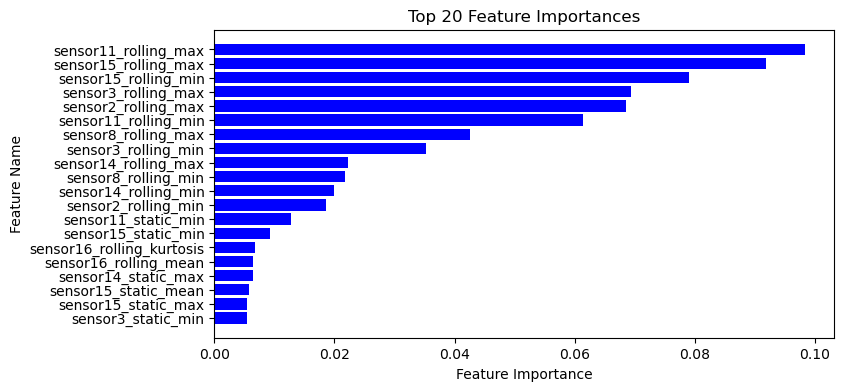

In [26]:
# Select features and target
X_train = train_df_scaled.drop(columns=['RUL', 'unit_id', 'cycle'])
y_train = train_df_scaled['RUL'] # Note: RUL is not scaled
X_test = test_df_scaled.drop(columns=['unit_id', 'cycle'])
y_test = RUL_df['RUL']

rf_model = RandomForestRegressor(random_state=42)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15],
    'min_samples_split': [6, 9, 12],
    'min_samples_leaf': [4, 6, 8],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True]
}

grid_search_rf = fit_model(X_train, y_train, rf_model, param_grid)

# Best parameters
print(f'Best Parameters: {grid_search_rf.best_params_}')

best_rf_model = grid_search_rf.best_estimator_

# Make predictions
rf_res_df = get_best_rmse(best_rf_model, X_train, X_test)

plot_feature_importances(best_rf_model, X_train.columns, 20)

### 1.8 Build ramdom forest model using rolling features

Fitting 3 folds for each of 162 candidates, totalling 486 fits
Best Parameters: {'bootstrap': True, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 400}
Root Mean Squared Error (RMSE) for train set prediction: 17.54000974632293
Root Mean Squared Error (RMSE) for test set prediction: 33.015863105478594


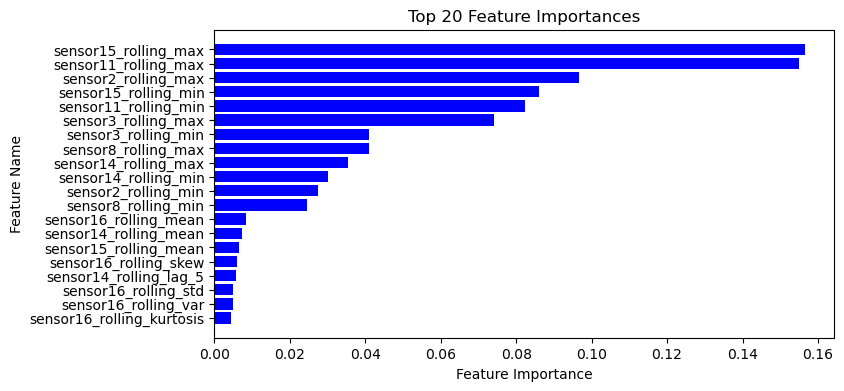

In [27]:
X_train_rolling = train_df_scaled.filter(like='rolling')
X_test_rolling = test_df_scaled.filter(like='rolling')

rf_rolling_model = RandomForestRegressor(random_state=42)

param_grid_rf_rolling = {
    'n_estimators': [200, 300, 400],
    'max_depth': [6, 8, 10],
    'min_samples_split': [6, 8, 10],
    'min_samples_leaf': [4, 6, 8],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True]
}

grid_search_rf_rolling = fit_model(X_train_rolling, y_train, rf_rolling_model, param_grid_rf_rolling)

# Best parameters
print(f'Best Parameters: {grid_search_rf_rolling.best_params_}')

best_rf_rolling_model = grid_search_rf_rolling.best_estimator_

# Make predictions
rf_rolling_res_df = get_best_rmse(best_rf_rolling_model, X_train_rolling, X_test_rolling)

plot_feature_importances(best_rf_rolling_model, X_train_rolling.columns, 20)

### 1.9 Build LightGBM model using all features

Fitting 3 folds for each of 1458 candidates, totalling 4374 fits


C:\ProgramData\anaconda3\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'min_child_samples': 30, 'n_estimators': 200, 'num_leaves': 10, 'reg_alpha': 0.1, 'subsample': 0.6}
Root Mean Squared Error (RMSE) for train set prediction: 9.447721554537894
Root Mean Squared Error (RMSE) for test set prediction: 43.57674805414723


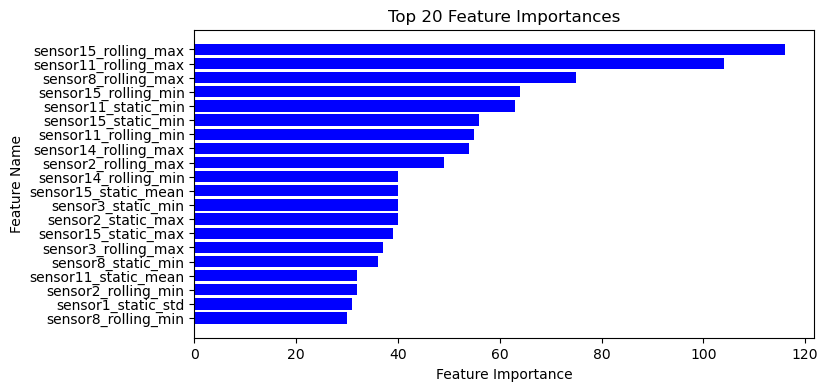

In [28]:
import lightgbm as lgb

lgb_model = lgb.LGBMRegressor(verbose=-1)

param_grid_lgb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [10, 15, 20],
    'min_child_samples': [20, 30, 40],
    'max_depth': [5, 7, 10],
    'subsample': [0.6, 0.8],
    'reg_alpha': [0.1, 0.5, 1.0]
}

grid_search_lgb = fit_model(X_train, y_train, lgb_model, param_grid_lgb)

# Best parameters
print(f'Best Parameters: {grid_search_lgb.best_params_}')

best_lgb_model = grid_search_lgb.best_estimator_

# Make predictions
lgb_res_df = get_best_rmse(best_lgb_model, X_train, X_test)

plot_feature_importances(best_lgb_model, X_train.columns, 20)

# Operation system clustering (EDA)

In [23]:
from tsfresh import extract_features
from tsfresh import select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.utilities.dataframe_functions import roll_time_series
from tsfresh.feature_selection.relevance import calculate_relevance_table
from tsfresh.feature_extraction import EfficientFCParameters

In [24]:
df=pd.read_csv(r'C:\\Users\\owner\\Desktop\\IT5006\\CMAPSSData\\train_FD002.txt', delim_whitespace=True, header=None)
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25
0,1,1,34.9983,0.8400,100.0,449.44,555.32,1358.61,1137.23,5.48,8.00,194.64,2222.65,8341.91,1.02,42.02,183.06,2387.72,8048.56,9.3461,0.02,334,2223,100.00,14.73,8.8071
1,1,2,41.9982,0.8408,100.0,445.00,549.90,1353.22,1125.78,3.91,5.71,138.51,2211.57,8303.96,1.02,42.20,130.42,2387.66,8072.30,9.3774,0.02,330,2212,100.00,10.41,6.2665
2,1,3,24.9988,0.6218,60.0,462.54,537.31,1256.76,1047.45,7.05,9.02,175.71,1915.11,8001.42,0.94,36.69,164.22,2028.03,7864.87,10.8941,0.02,309,1915,84.93,14.08,8.6723
3,1,4,42.0077,0.8416,100.0,445.00,549.51,1354.03,1126.38,3.91,5.71,138.46,2211.58,8303.96,1.02,41.96,130.72,2387.61,8068.66,9.3528,0.02,329,2212,100.00,10.59,6.4701
4,1,5,25.0005,0.6203,60.0,462.54,537.07,1257.71,1047.93,7.05,9.03,175.05,1915.10,7993.23,0.94,36.89,164.31,2028.00,7861.23,10.8963,0.02,309,1915,84.93,14.13,8.5286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53754,260,312,20.0037,0.7000,100.0,491.19,608.79,1495.60,1269.51,9.35,13.66,334.00,2324.92,8852.27,1.07,44.72,314.05,2389.02,8169.64,9.3035,0.03,369,2324,100.00,24.36,14.5189
53755,260,313,10.0022,0.2510,100.0,489.05,605.81,1514.32,1324.12,10.52,15.50,392.46,2319.17,8915.86,1.26,46.08,371.22,2388.42,8245.36,8.7586,0.03,374,2319,100.00,28.10,16.9454
53756,260,314,25.0041,0.6200,60.0,462.54,537.48,1276.24,1057.92,7.05,9.04,175.11,1917.37,8114.33,0.94,37.14,163.74,2030.33,7971.25,11.0657,0.02,310,1915,84.93,14.19,8.5503
53757,260,315,25.0033,0.6220,60.0,462.54,537.84,1272.95,1066.30,7.05,9.04,174.81,1917.36,8112.63,0.94,37.32,164.37,2030.35,7972.47,11.0537,0.02,311,1915,84.93,14.05,8.3729


In [25]:
col_1=['unit','time','op1','op2','op3']
col_2=[]
for i in range(21):
    col=f'sr{i+1}'
    col_2.append(col)
columns=col_1+col_2
df.columns=columns
df['max_time']=df.groupby('unit')['time'].transform('max')
df['remaining_time']=df['max_time']-df['time']
df['label']=df['remaining_time'].clip(upper=130)
df.head()

,unit,time,op1,op2,op3,sr1,sr2,sr3,sr4,sr5,sr6,sr7,sr8,sr9,sr10,sr11,sr12,sr13,sr14,sr15,sr16,sr17,sr18,sr19,sr20,sr21,max_time,remaining_time,label
0,1,1,34.9983,0.8400,100.0,449.44,555.32,1358.61,1137.23,5.48,8.00,194.64,2222.65,8341.91,1.02,42.02,183.06,2387.72,8048.56,9.3461,0.02,334,2223,100.00,14.73,8.8071,149,148,130
1,1,2,41.9982,0.8408,100.0,445.00,549.90,1353.22,1125.78,3.91,5.71,138.51,2211.57,8303.96,1.02,42.20,130.42,2387.66,8072.30,9.3774,0.02,330,2212,100.00,10.41,6.2665,149,147,130
2,1,3,24.9988,0.6218,60.0,462.54,537.31,1256.76,1047.45,7.05,9.02,175.71,1915.11,8001.42,0.94,36.69,164.22,2028.03,7864.87,10.8941,0.02,309,1915,84.93,14.08,8.6723,149,146,130
3,1,4,42.0077,0.8416,100.0,445.00,549.51,1354.03,1126.38,3.91,5.71,138.46,2211.58,8303.96,1.02,41.96,130.72,2387.61,8068.66,9.3528,0.02,329,2212,100.00,10.59,6.4701,149,145,130
4,1,5,25.0005,0.6203,60.0,462.54,537.07,1257.71,1047.93,7.05,9.03,175.05,1915.10,7993.23,0.94,36.89,164.31,2028.00,7861.23,10.8963,0.02,309,1915,84.93,14.13,8.5286,149,144,130


array([[<Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >]], dtype=object)

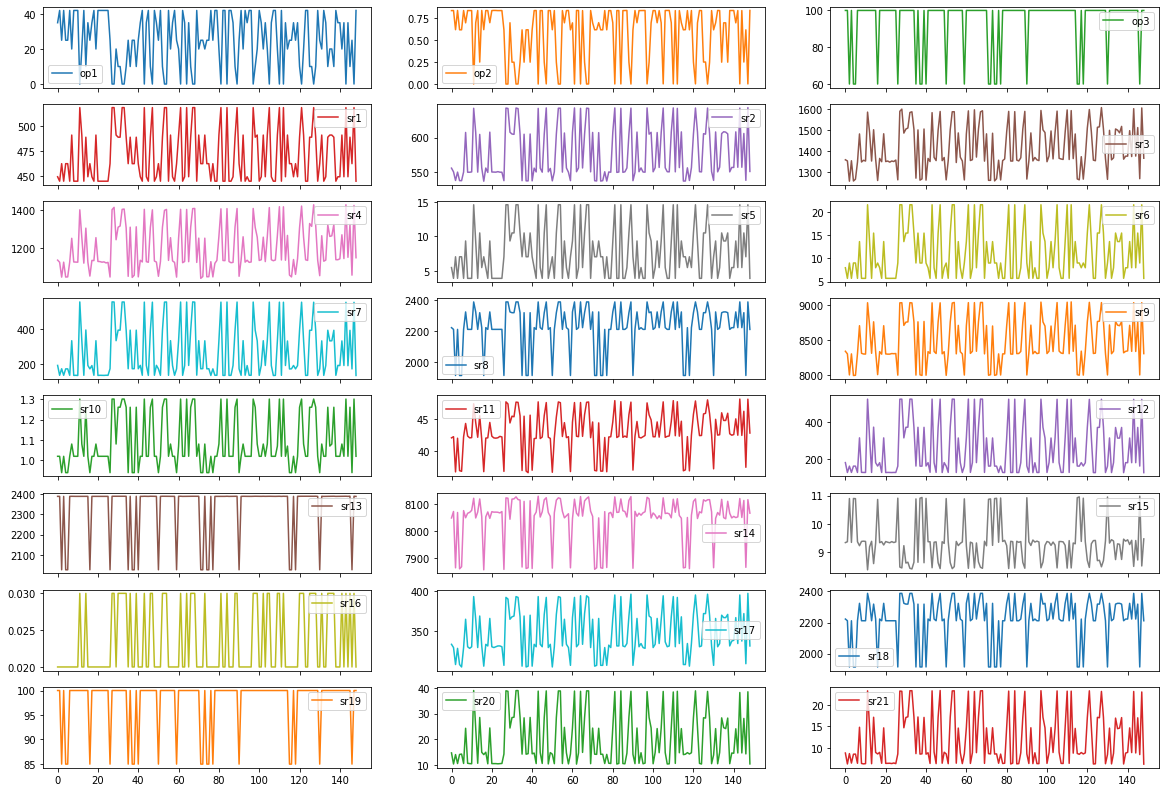

In [26]:
df_1=df[df['unit']==1].iloc[:,2:]
df_1[['op1', 'op2', 'op3','sr1', 'sr2', 'sr3', 'sr4', 'sr5', 'sr6', 'sr7', 'sr8', 'sr9', 'sr10',
      'sr11', 'sr12', 'sr13', 'sr14', 'sr15', 'sr16', 'sr17', 'sr18', 'sr19', 'sr20', 'sr21']].plot(subplots=True, figsize=(20, 14), layout=(8, 3))

For FD002, we chose to use all sensors

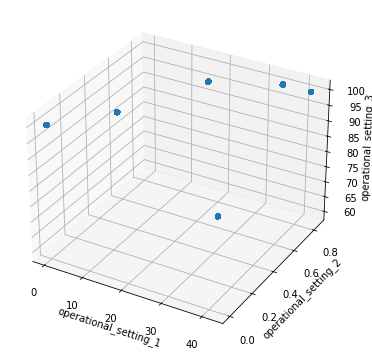

In [27]:

from mpl_toolkits.mplot3d import Axes3D
op1=df.iloc[:,2]
op2=df.iloc[:,3]
op3=df.iloc[:,4]
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(op1, op2, op3)
ax.set_xlabel('operational_setting_1')
ax.set_ylabel('operational_setting_2')
ax.set_zlabel('operational_setting_3')
ax.tick_params(axis='x', pad=8)
ax.tick_params(axis='y', pad=8)
ax.tick_params(axis='z', pad=8)
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'op3')

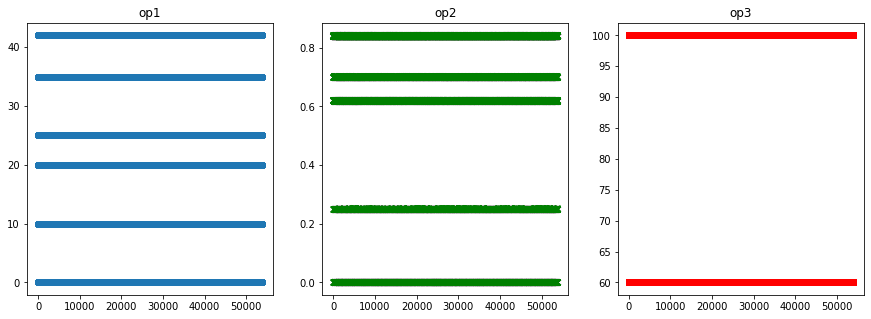

In [28]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].scatter(df.index, df['op1'], marker='o', label='op1')
axs[0].set_title('op1')
axs[1].scatter(df.index, df['op2'], marker='x', label='op2', color='g')
axs[1].set_title('op2')
axs[2].scatter(df.index, df['op3'], marker='s', label='op3', color='r')
axs[2].set_title('op3')

In [29]:
# type1: op1 in [0,1], op2 in [0,1], op3 in [99,100]
# type2: op1 in [9,11], op2 in [0.2,0.3], op3 in [99, 100]
# type3: op1 in [19,21], op2 in [0.65, 0.75], op3 in [99, 100]
# type4: op1 in [24, 26], op2 in [0.6, 0.63], op3 in [59, 61]
# type5: op1 in [30, 40], op2 >=0.8, op3 in [99, 100]
# type6: op1 >=40, op2>=0.8, op3 in [99, 100]
df_ops=df[['op1','op2','op3']]
conditions = [
    (df['op1'].between(0, 1)) & (df['op2'].between(0, 1)) & (df['op3'].between(99, 100)),  # type1
    (df['op1'].between(9, 11)) & (df['op2'].between(0.2, 0.3)) & (df['op3'].between(99, 100)),  # type2
    (df['op1'].between(19, 21)) & (df['op2'].between(0.65, 0.75)) & (df['op3'].between(99, 100)),  # type3
    (df['op1'].between(24, 26)) & (df['op2'].between(0.6, 0.63)) & (df['op3'].between(59, 61)),  # type4
    (df['op1'].between(30, 40)) & (df['op2'] >= 0.8) & (df['op3'].between(99, 100)),  # type5
    (df['op1'] >= 40) & (df['op2'] >= 0.8) & (df['op3'].between(99, 100))  # type6
]
type_labels = ['type1', 'type2', 'type3', 'type4', 'type5', 'type6']
df_ops['type'] = np.select(conditions, type_labels, default='undefined')
df_ops

C:\Users\owner\AppData\Local\Temp\ipykernel_33924\294332328.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ops['type'] = np.select(conditions, type_labels, default='undefined')


,op1,op2,op3,type
0,34.9983,0.8400,100.0,type5
1,41.9982,0.8408,100.0,type6
2,24.9988,0.6218,60.0,type4
3,42.0077,0.8416,100.0,type6
4,25.0005,0.6203,60.0,type4
...,...,...,...,...
53754,20.0037,0.7000,100.0,type3
53755,10.0022,0.2510,100.0,type2
53756,25.0041,0.6200,60.0,type4
53757,25.0033,0.6220,60.0,type4


In [30]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore') 
X_ops=ohe.fit_transform(df_ops[['type']])
X_ops 

array([[0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.]])

In [31]:
column_names = ['type1', 'type2', 'type3', 'type4', 'type5', 'type6']
df_ops = pd.DataFrame(X_ops, columns=column_names)
df_ops

,type1,type2,type3,type4,type5,type6
0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...
53754,0.0,0.0,1.0,0.0,0.0,0.0
53755,0.0,1.0,0.0,0.0,0.0,0.0
53756,0.0,0.0,0.0,1.0,0.0,0.0
53757,0.0,0.0,0.0,1.0,0.0,0.0


# Experiment 3: Various ML & DL Models Using All Features with Tsfresh

In [32]:
col_1 = ['unit', 'time', 'op1', 'op2', 'op3']
col_2 = [f'sr{i+1}' for i in range(21)]
columns = col_1 + col_2

# Load datasets and assign column names
df = pd.read_csv(r'C:\\Users\\owner\\Desktop\\IT5006\\CMAPSSData\\train_FD002.txt', delim_whitespace=True, header=None, names=columns)
test = pd.read_csv(r'C:\\Users\\owner\\Desktop\\IT5006\\CMAPSSData\\test_FD002.txt', delim_whitespace=True, header=None, names=columns)

# Add features to training data
df['max_time'] = df.groupby('unit')['time'].transform('max')
df['remaining_time'] = df['max_time'] - df['time']
df['label'] = df['remaining_time'].clip(upper=130)


### 3.1 Data processing
window size of 60 with min_timeshift change to 5 to retain all test labels

In [33]:
window_size = 60
rolling_params = {
    "column_id": "unit",
    "column_sort": "time",
    "max_timeshift": window_size - 1,
    "min_timeshift": 5,
    "rolling_direction": 1
}

# Function to roll time series data
def roll_data(df, **params):
    return roll_time_series(df, **params)

# Roll the datasets
rolled_df = roll_data(df, **rolling_params)
rolled_test = roll_data(test, **rolling_params)

rolled_df

Rolling: 100%|██████████| 53/53 [00:10<00:00,  5.20it/s]


,unit,time,op1,op2,op3,sr1,sr2,sr3,sr4,sr5,sr6,sr7,sr8,sr9,sr10,sr11,sr12,sr13,sr14,sr15,sr16,sr17,sr18,sr19,sr20,sr21,max_time,remaining_time,label,id
0,1,1,34.9983,0.8400,100.0,449.44,555.32,1358.61,1137.23,5.48,8.00,194.64,2222.65,8341.91,1.02,42.02,183.06,2387.72,8048.56,9.3461,0.02,334,2223,100.00,14.73,8.8071,149,148,130,"(1, 6)"
1,1,2,41.9982,0.8408,100.0,445.00,549.90,1353.22,1125.78,3.91,5.71,138.51,2211.57,8303.96,1.02,42.20,130.42,2387.66,8072.30,9.3774,0.02,330,2212,100.00,10.41,6.2665,149,147,130,"(1, 6)"
2,1,3,24.9988,0.6218,60.0,462.54,537.31,1256.76,1047.45,7.05,9.02,175.71,1915.11,8001.42,0.94,36.69,164.22,2028.03,7864.87,10.8941,0.02,309,1915,84.93,14.08,8.6723,149,146,130,"(1, 6)"
3,1,4,42.0077,0.8416,100.0,445.00,549.51,1354.03,1126.38,3.91,5.71,138.46,2211.58,8303.96,1.02,41.96,130.72,2387.61,8068.66,9.3528,0.02,329,2212,100.00,10.59,6.4701,149,145,130,"(1, 6)"
4,1,5,25.0005,0.6203,60.0,462.54,537.07,1257.71,1047.93,7.05,9.03,175.05,1915.10,7993.23,0.94,36.89,164.31,2028.00,7861.23,10.8963,0.02,309,1915,84.93,14.13,8.5286,149,144,130,"(1, 6)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2748175,260,312,20.0037,0.7000,100.0,491.19,608.79,1495.60,1269.51,9.35,13.66,334.00,2324.92,8852.27,1.07,44.72,314.05,2389.02,8169.64,9.3035,0.03,369,2324,100.00,24.36,14.5189,316,4,4,"(260, 316)"
2748176,260,313,10.0022,0.2510,100.0,489.05,605.81,1514.32,1324.12,10.52,15.50,392.46,2319.17,8915.86,1.26,46.08,371.22,2388.42,8245.36,8.7586,0.03,374,2319,100.00,28.10,16.9454,316,3,3,"(260, 316)"
2748177,260,314,25.0041,0.6200,60.0,462.54,537.48,1276.24,1057.92,7.05,9.04,175.11,1917.37,8114.33,0.94,37.14,163.74,2030.33,7971.25,11.0657,0.02,310,1915,84.93,14.19,8.5503,316,2,2,"(260, 316)"
2748178,260,315,25.0033,0.6220,60.0,462.54,537.84,1272.95,1066.30,7.05,9.04,174.81,1917.36,8112.63,0.94,37.32,164.37,2030.35,7972.47,11.0537,0.02,311,1915,84.93,14.05,8.3729,316,1,1,"(260, 316)"


In [5]:
rolled_test

,unit,time,op1,op2,op3,sr1,sr2,sr3,sr4,sr5,...,sr13,sr14,sr15,sr16,sr17,sr18,sr19,sr20,sr21,id
0,1,1,9.9987,0.2502,100.0,489.05,605.03,1497.17,1304.99,10.52,...,2388.18,8114.10,8.6476,0.03,369,2319,100.00,28.42,17.1551,"(1, 6)"
1,1,2,20.0026,0.7000,100.0,491.19,607.82,1481.20,1246.11,9.35,...,2388.12,8053.06,9.2405,0.02,364,2324,100.00,24.29,14.8039,"(1, 6)"
2,1,3,35.0045,0.8400,100.0,449.44,556.00,1359.08,1128.36,5.48,...,2387.75,8053.04,9.3472,0.02,333,2223,100.00,14.98,8.9125,"(1, 6)"
3,1,4,42.0066,0.8410,100.0,445.00,550.17,1349.69,1127.89,3.91,...,2387.72,8066.90,9.3961,0.02,332,2212,100.00,10.35,6.4181,"(1, 6)"
4,1,5,24.9985,0.6213,60.0,462.54,536.72,1253.18,1050.69,7.05,...,2028.05,7865.66,10.8682,0.02,305,1915,84.93,14.31,8.5740,"(1, 6)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1470189,259,119,35.0015,0.8403,100.0,449.44,555.56,1366.01,1129.47,5.48,...,2388.39,8088.36,9.3215,0.02,334,2223,100.00,14.94,8.9065,"(259, 123)"
1470190,259,120,42.0066,0.8405,100.0,445.00,549.42,1351.13,1123.86,3.91,...,2388.31,8108.48,9.3542,0.02,332,2212,100.00,10.57,6.4075,"(259, 123)"
1470191,259,121,42.0061,0.8400,100.0,445.00,549.65,1349.14,1118.91,3.91,...,2388.34,8098.77,9.3836,0.02,331,2212,100.00,10.57,6.4805,"(259, 123)"
1470192,259,122,0.0024,0.0003,100.0,518.67,642.58,1589.61,1408.16,14.62,...,2388.00,8161.85,8.4279,0.03,393,2388,100.00,39.08,23.3589,"(259, 123)"


In [ ]:
selected_cols=['id', 'sr1','sr2', 'sr3', 'sr4', 'sr5',
               'sr6', 'sr7', 'sr8', 'sr9', 'sr10',
                'sr11', 'sr12', 'sr13', 'sr14', 'sr15',
                'sr16', 'sr17', 'sr18', 'sr19', 'sr20', 'sr21']
selected_df=rolled_df[selected_cols]
selected_test=rolled_test[selected_cols]

unique_ids = selected_df['id'].unique()

# Split the unique ids into two halves
midpoint = len(unique_ids) // 2
first_half_ids = unique_ids[:midpoint]  # First half of unique ids
second_half_ids = unique_ids[midpoint:]  # Second half of unique ids

# Filter the DataFrame for each half based on the unique ids
first_half_df = selected_df[selected_df['id'].isin(first_half_ids)]
second_half_df = selected_df[selected_df['id'].isin(second_half_ids)]

print(len(first_half_df)+ len(second_half_df))

### 3.2 Feature engineering and selection with Tsfresh

In [ ]:
extraction_settings = EfficientFCParameters()

# Helper function to extract features
def extract_features_helper(df, **params):
    return extract_features(df, **params)

# Common parameters for feature extraction
feature_params = {
    "column_id": "id",
    "impute_function": impute,
    "default_fc_parameters": extraction_settings
}

# Apply feature extraction
X1 = extract_features_helper(first_half_df, **feature_params)
X2 = extract_features_helper(second_half_df, **feature_params)
X = pd.concat([X1, X2], axis=0)

x_test = extract_features_helper(selected_test, **feature_params)

In [34]:
y=rolled_df.groupby('id')['label'].last()
# X_filtered=select_features(X, y)

As extraction and feature selection of FD002 takes more than few hours, resulting X_filtered and x_test was saved beforehand for future use.

In [ ]:
# X_filtered.to_csv('C:\\Users\\owner\\Desktop\\IT5006\\FD002_X_filtered.csv', index=False)
# x_test.to_csv('C:\\Users\\owner\\Desktop\\IT5006\\FD002_X_test.csv', index=False)

In [ ]:
# X_filtered = pd.read_csv('C:\\Users\\owner\\Desktop\\IT5006\\FD002_X_filtered.csv')
# x_test = pd.read_csv('C:\\Users\\owner\\Desktop\\IT5006\\FD002_X_test.csv')

In [36]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_filtered)
relevant_features_scaled = scaler.transform(X_filtered)
relevant_features_scaled_df = pd.DataFrame(relevant_features_scaled, columns=X_filtered.columns)

selected_features = relevant_features_scaled_df.columns 
relevant_test_features = x_test[selected_features]
relevant_test_features_scaled = scaler.transform(relevant_test_features)
relevant_test_features_scaled_df = pd.DataFrame(relevant_test_features_scaled, columns=selected_features)

In [9]:
print(selected_features)

Index(['sr1__sum_values', 'sr11__quantile__q_0.3', 'sr11__quantile__q_0.4',
       'sr11__quantile__q_0.6', 'sr11__quantile__q_0.7',
       'sr11__quantile__q_0.8', 'sr11__quantile__q_0.9',
       'sr11__agg_autocorrelation__f_agg_"mean"__maxlag_40',
       'sr11__agg_autocorrelation__f_agg_"var"__maxlag_40',
       'sr11__number_cwt_peaks__n_1',
       ...
       'sr20__fft_coefficient__attr_"real"__coeff_30',
       'sr17__fft_coefficient__attr_"real"__coeff_25',
       'sr13__fft_coefficient__attr_"angle"__coeff_3',
       'sr4__fft_coefficient__attr_"angle"__coeff_19',
       'sr7__fft_coefficient__attr_"real"__coeff_30',
       'sr21__fft_coefficient__attr_"real"__coeff_30',
       'sr12__fft_coefficient__attr_"real"__coeff_30',
       'sr1__fft_coefficient__attr_"real"__coeff_25',
       'sr20__cwt_coefficients__coeff_11__w_2__widths_(2, 5, 10, 20)',
       'sr21__cwt_coefficients__coeff_12__w_2__widths_(2, 5, 10, 20)'],
      dtype='object', length=7213)


### 3.3 predictive modelling

In [37]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(relevant_features_scaled_df, y, test_size=0.2, random_state=42)

In [38]:
def calculate_s_score(y_true, y_pred):
    # Calculate the error between predictions and actual values
    error = y_pred - y_true
    
    # Apply S-score calculation
    s_score = np.where(
        error <= 0, 
        np.exp(-error / 13) - 1, 
        np.exp(error / 10) - 1
    )
    
    # Return the mean S-score
    return np.mean(s_score)


def evaluate_model(model, X_train, y_train, X_val, y_val, X_test=None, Y_test=None):
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions on validation set
    y_pred = model.predict(X_val)
    
    # Calculate evaluation metrics for validation
    s_score = calculate_s_score(y_val, y_pred)
    mse_val = mean_squared_error(y_val, y_pred)
    rmse_val = mse_val ** 0.5
    
    # Print validation results
    model_name = model.__class__.__name__
    print(f'{model_name} model - Validation Set')
    print('RMSE:', rmse_val)
    print('S-score:', s_score)
    print('---------------------')
    
    results = {'model': model_name, 'rmse_val': rmse_val, 's_score': s_score}
    
    # If test set provided, predict and evaluate on test set
    if X_test is not None and Y_test is not None:
        y_pred_test = model.predict(X_test)
        temp = rolled_test.groupby('id').last()
        temp['prediction'] = y_pred_test
        Y_pred = temp.groupby('unit')['prediction'].last().to_numpy()
        
        # Calculate RMSE for test set
        s_test = calculate_s_score(Y_test, Y_pred)
        mse_test = mean_squared_error(Y_test, Y_pred)
        rmse_test = mse_test ** 0.5
        print(f'{model_name} model - Test Set')
        print('Test RMSE:', rmse_test)
        print('Test score:', s_test)
        print('---------------------')
        
        # Store test results in the results dictionary
        results.update({'rmse_test': rmse_test, 'test_score': s_test})
    
    return results

In [2]:
rul_file_path = 'C:\\Users\\owner\\Desktop\\IT5006\\CMAPSSData\\RUL_FD002.txt'
true_rul = pd.read_csv(rul_file_path, header=None, names=['RUL'])
true_rul['RUL'] = true_rul['RUL'].clip(upper=130)

# Assign the true RUL values to Y_test
y_test = true_rul['RUL']

In [ ]:
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.base import BaseEstimator, RegressorMixin


def scheduler(epoch, optimizer):
    if epoch < 5:
        lr = 0.001
    else:
        lr = 0.0001
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr


class ConvLSTMModel(nn.Module):
    def __init__(self, input_channels, drop_CNN=0.1, drop_dense=0.1, kernel_size=3):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels=input_channels, out_channels=128, kernel_size=kernel_size, padding=kernel_size//2)
        self.dropout1 = nn.Dropout(p=drop_CNN)
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2, padding=1)

        self.conv2 = nn.Conv1d(in_channels=128, out_channels=128, kernel_size=kernel_size, padding=kernel_size//2)
        self.dropout2 = nn.Dropout(p=drop_CNN)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2, padding=1)

        self.lstm1 = nn.LSTM(input_size=128, hidden_size=128, num_layers=1, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=128, hidden_size=128, num_layers=1, batch_first=True)

        self.dropout3 = nn.Dropout(p=drop_dense)
        self.dense1 = nn.Linear(128, 512)
        self.dense2 = nn.Linear(512, 128)
        self.dense3 = nn.Linear(128, 1)

    def forward(self, x):
        # x shape: (batch_size, window_length, input_channels)
        x = x.permute(0, 2, 1)  # Convert to (batch_size, input_channels, window_length)
        x = F.relu(self.conv1(x))
        x = self.dropout1(x)
        x = self.pool1(x)

        x = F.relu(self.conv2(x))
        x = self.dropout2(x)
        x = self.pool2(x)

        x = x.permute(0, 2, 1)  # Convert to (batch_size, seq_length, channels)

        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x = x[:, -1, :]

        # Dropout layer
        x = self.dropout3(x)

        x = F.relu(self.dense1(x))
        x = F.relu(self.dense2(x))
        x = self.dense3(x)
        
        return x


class ConvLSTMRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, input_channels=1, lr=0.001, batch_size=64, max_epoch=500, drop_CNN=0.1, drop_dense=0.1, kernel_size=3):
        self.lr = lr
        self.batch_size = batch_size
        self.max_epoch = max_epoch
        self.model = ConvLSTMModel(input_channels=input_channels, drop_CNN=drop_CNN, drop_dense=drop_dense, kernel_size=kernel_size)

    def _prepare_input(self, X):
        """
        Detect input data dimensions:
        If the input is two-dimensional data (samples, features), a pseudo-time dimension is added (samples, 1, features).
        If the input is three-dimensional data (samples, seq_length, channels), it is returned directly.
        """
        if X.ndim == 2:
            X = np.expand_dims(X, axis=1)  # 增加伪时间维度
        return X

        
    def fit(self, X, y):
        # Detect and adjust input data dimensions
        X = self._prepare_input(X)

        # Convert X, y to torch tensors
        X_tensor = torch.tensor(X, dtype=torch.float32)
        y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1)

        # Define optimizer
        optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
        criterion = nn.MSELoss()

        # Training loop
        self.model.train()
        for epoch in range(self.max_epoch):
            running_loss = 0.0
            permutation = torch.randperm(X_tensor.size(0))
            for i in range(0, X_tensor.size(0), self.batch_size):
                indices = permutation[i:i + self.batch_size]
                batch_x, batch_y = X_tensor[indices], y_tensor[indices]

                optimizer.zero_grad()
                outputs = self.model(batch_x)
                loss = criterion(outputs, batch_y)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()

            if (epoch + 1) % 1 == 0:
                print(f"Epoch {epoch + 1}/{self.max_epoch}, Loss: {running_loss/X_tensor.size(0):.4f}")

            # adjust learning rate based on epoch
            scheduler(epoch, optimizer)

        return self

    def predict(self, X):
        # Detect and adjust input data dimensions
        X = self._prepare_input(X)

        # Convert X to torch tensor
        X_tensor = torch.tensor(X, dtype=torch.float32)
        
        # Prediction
        self.model.eval()
        with torch.no_grad():
            predictions = self.model(X_tensor).numpy()
        
        return predictions.flatten()


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
# from cnn_lstm import ConvLSTMRegressor


# List of models to evaluate
models = [XGBRegressor(objective='reg:squarederror',random_state=42,n_estimators=50,max_depth=6,min_child_weight=5,learning_rate=0.1,subsample=0.8,colsample_bytree=0.8,tree_method='hist'),
          RandomForestRegressor(n_estimators=50,max_depth=15,max_features="sqrt",min_samples_split=10,min_samples_leaf=5,n_jobs=-1),
          MLPRegressor(hidden_layer_sizes=(50, 50), solver="adam", batch_size=64, learning_rate="adaptive", learning_rate_init=0.01, max_iter=500),
          ConvLSTMRegressor(input_channels=X_train.shape[-1], batch_size=64, lr=0.001, max_epoch=10)]
          

# Evaluate each model
results = []
for model in models:
    result = evaluate_model(model, X_train, y_train, X_val, y_val, X_test=relevant_test_features_scaled_df, Y_test=y_test)
    results.append(result)

# If you want, you can compile the results into a DataFrame for easy comparison

results_df = pd.DataFrame(results)
print(results_df)

XGBRegressor model - Validation Set
RMSE: 10.10594709471376
S-score: 1.599498383000104
---------------------
XGBRegressor model - Test Set
Test RMSE: 16.258879861827932
Test score: 4.420119902579336
---------------------
RandomForestRegressor model - Validation Set
RMSE: 8.407301621015241
S-score: 1.0605942361266198
---------------------
RandomForestRegressor model - Test Set
Test RMSE: 19.2943558893475
Test score: 6.297240779167225
---------------------
MLPRegressor model - Validation Set
RMSE: 3.640587052432422
S-score: 0.2822270560287698
---------------------
MLPRegressor model - Test Set
Test RMSE: 18.686837214465086
Test score: 6.754682343776111
---------------------
Epoch 1/10, Loss: 13.5053
Epoch 2/10, Loss: 1.6203
Epoch 3/10, Loss: 0.9324
Epoch 4/10, Loss: 0.7078
Epoch 5/10, Loss: 0.5955
Epoch 6/10, Loss: 0.5378
Epoch 7/10, Loss: 0.3994
Epoch 8/10, Loss: 0.3355
Epoch 9/10, Loss: 0.3118
Epoch 10/10, Loss: 0.3003
ConvLSTMRegressor model - Validation Set
RMSE: 3.446971740522961
S-

### 3.4 PCA dimension reduction to prevent overfitting

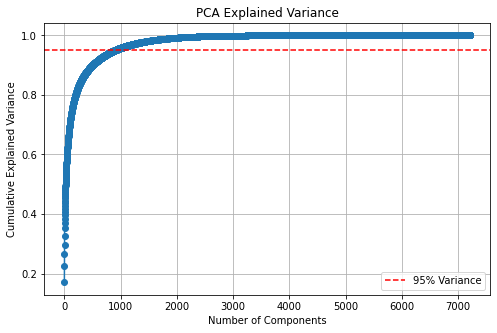

Optimal number of components for 95% variance: 900


In [41]:
from sklearn.decomposition import PCA
pca = PCA()  # Adjust based on your dataset
pca.fit(X_train)

# Calculate cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot cumulative explained variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance')
plt.legend()
plt.grid(True)
plt.show()

# Find the optimal number of components to retain at least 95% variance
optimal_n_components = np.argmax(cumulative_variance >= 0.95) + 1
print("Optimal number of components for 95% variance:", optimal_n_components)

In [42]:
from sklearn.decomposition import PCA
pca = PCA(n_components=optimal_n_components)  # Adjust based on your dataset
X_train_reduced = pca.fit_transform(X_train)
X_val_reduced = pca.transform(X_val)
X_test_reduced = pca.transform(relevant_test_features_scaled_df)

In [43]:
# List of models to evaluate
models = [XGBRegressor(objective='reg:squarederror',random_state=42,n_estimators=50,max_depth=6,min_child_weight=5,learning_rate=0.1,subsample=0.8,colsample_bytree=0.8,tree_method='hist'),
          RandomForestRegressor(n_estimators=50,max_depth=15,max_features="sqrt",min_samples_split=10,min_samples_leaf=5,n_jobs=-1),
          MLPRegressor(hidden_layer_sizes=(50, 50), solver="adam", batch_size=64, learning_rate="adaptive", learning_rate_init=0.01, max_iter=500),
          ConvLSTMRegressor(input_channels=X_train_reduced.shape[-1], batch_size=64, lr=0.001, max_epoch=10)]

# Evaluate each model
results = []
for model in models:
    result = evaluate_model(model, X_train_reduced, y_train, X_val_reduced, y_val, X_test=X_test_reduced, Y_test=y_test)
    results.append(result)

# If you want, you can compile the results into a DataFrame for easy comparison
import pandas as pd
results_df = pd.DataFrame(results)
print(results_df)

XGBRegressor model - Validation Set
RMSE: 21.088397087436
S-score: 12.110075932416734
---------------------
XGBRegressor model - Test Set
Test RMSE: 26.95523816371529
Test score: 47.12041038937964
---------------------
RandomForestRegressor model - Validation Set
RMSE: 29.273713854128506
S-score: 32.26369769724985
---------------------
RandomForestRegressor model - Test Set
Test RMSE: 35.88352861868297
Test score: 89.60788885257841
---------------------
MLPRegressor model - Validation Set
RMSE: 6.044493855631314
S-score: 0.5864260830341389
---------------------
MLPRegressor model - Test Set
Test RMSE: 20.32200067855581
Test score: 9.202018621215919
---------------------
Epoch 1/10, Loss: 9.1629
Epoch 2/10, Loss: 0.9800
Epoch 3/10, Loss: 0.6898
Epoch 4/10, Loss: 0.5766
Epoch 5/10, Loss: 0.5192
Epoch 6/10, Loss: 0.4610
Epoch 7/10, Loss: 0.3542
Epoch 8/10, Loss: 0.2944
Epoch 9/10, Loss: 0.2730
Epoch 10/10, Loss: 0.2563
ConvLSTMRegressor model - Validation Set
RMSE: 3.537779383552228
S-sco

### 3.5 residual plot

result did not improve after PCA dimension reduction

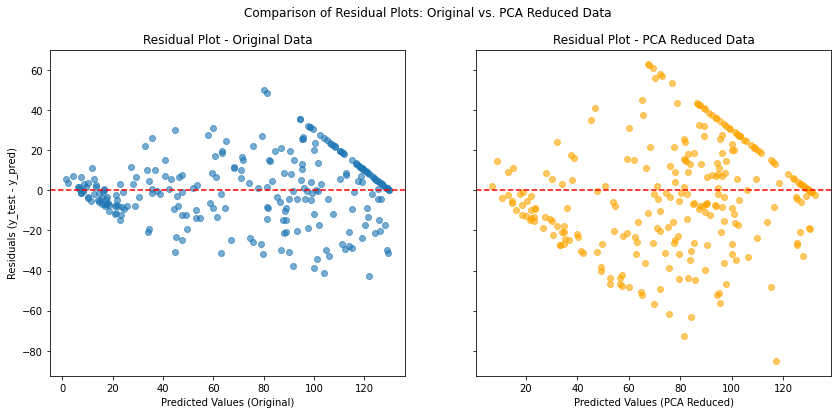

In [44]:
XGBoost= XGBRegressor(objective='reg:squarederror',random_state=42,n_estimators=50,max_depth=6,min_child_weight=5,learning_rate=0.1,subsample=0.8,colsample_bytree=0.8,tree_method='hist')
XGBoost.fit(X_train, y_train)
y_pred = XGBoost.predict(relevant_test_features_scaled_df)
temp = rolled_test.groupby('id').last()
temp['prediction'] = y_pred
y_pred_original = temp.groupby('unit')['prediction'].last().to_numpy()

XGBoost= XGBRegressor(objective='reg:squarederror',random_state=42,n_estimators=50,max_depth=6,min_child_weight=5,learning_rate=0.1,subsample=0.8,colsample_bytree=0.8,tree_method='hist')
XGBoost.fit(X_train_reduced, y_train)
y_pred = XGBoost.predict(X_test_reduced)
temp = rolled_test.groupby('id').last()
temp['prediction'] = y_pred
y_pred_pca = temp.groupby('unit')['prediction'].last().to_numpy()

residuals_original = y_test - y_pred_original
residuals_pca = y_test - y_pred_pca

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Original data residual plot
axes[0].scatter(y_pred_original, residuals_original, alpha=0.6)
axes[0].axhline(y=0, color='red', linestyle='--')
axes[0].set_xlabel("Predicted Values (Original)")
axes[0].set_ylabel("Residuals (y_test - y_pred)")
axes[0].set_title("Residual Plot - Original Data")

# PCA-reduced data residual plot
axes[1].scatter(y_pred_pca, residuals_pca, alpha=0.6, color="orange")
axes[1].axhline(y=0, color='red', linestyle='--')
axes[1].set_xlabel("Predicted Values (PCA Reduced)")
axes[1].set_title("Residual Plot - PCA Reduced Data")

plt.suptitle("Comparison of Residual Plots: Original vs. PCA Reduced Data")
plt.show()

### 3.6 feature importance

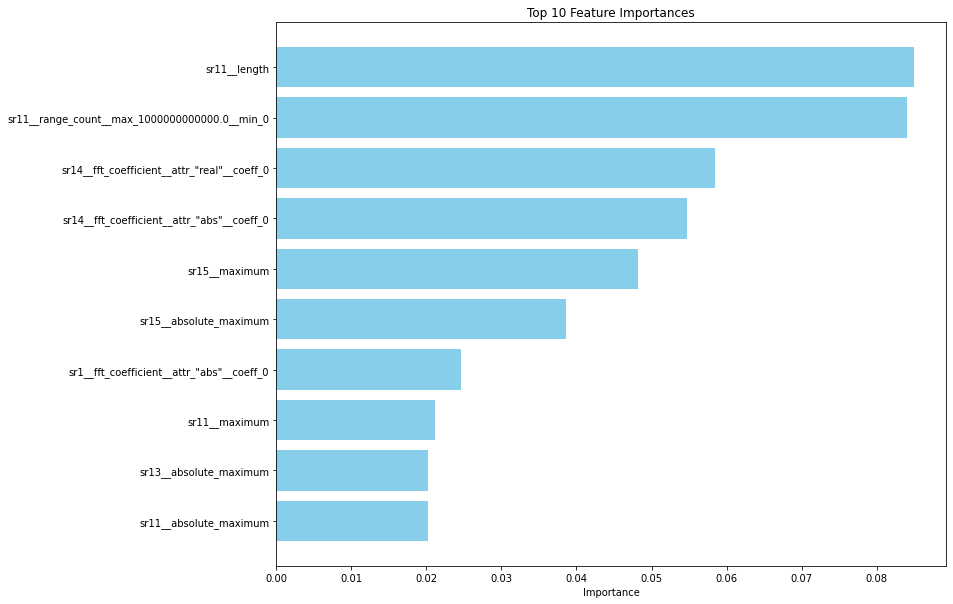

In [45]:
XGBoost= XGBRegressor(objective='reg:squarederror',random_state=42,n_estimators=50,max_depth=6,min_child_weight=5,learning_rate=0.1,subsample=0.8,colsample_bytree=0.8,tree_method='hist')
XGBoost.fit(X_train, y_train)

# Get feature importances
importances = XGBoost.feature_importances_

# Create a DataFrame for easy sorting and selection
feature_importances = pd.DataFrame({
    'Feature': X_train.columns,  # Adjust if feature names are in a different variable
    'Importance': importances
})

# Sort by importance and select the top 100 features
top_10_features = feature_importances.sort_values(by='Importance', ascending=False).head(10)

plt.figure(figsize=(12, 10))
plt.barh(top_10_features['Feature'], top_10_features['Importance'], color='skyblue')
plt.xlabel("Importance")
plt.title("Top 10 Feature Importances")
plt.gca().invert_yaxis()  # Invert y-axis to show the highest importance at the top
plt.show()

# Mean Predictor Model

In [3]:
from sklearn.metrics import mean_squared_error
y_mean_pred =[sum(y_test)/len(y_test)]* len(y_test)
rmse_mean_pred = np.sqrt(mean_squared_error(y_test, y_mean_pred))
print(f'Root Mean Squared Error (RMSE)for mean predictor: {rmse_mean_pred}')

Root Mean Squared Error (RMSE)for mean predictor: 44.245941213902164
